#  Прогнозирование заказов такси

Компания **«Чётенькое такси»** собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час.

**Цель:** Построить модель для предсказания количество заказов такси на будущий час.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

**Задачи:**

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders`.

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Итоговые-выводы" data-toc-modified-id="Итоговые-выводы-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Итоговые выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

## Подготовка

In [1]:
# Импорт библиотек
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import make_scorer, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf

from sklearn.metrics import make_scorer, mean_squared_error
rmse_scorer = make_scorer(mean_squared_error, squared=False, greater_is_better=False)

from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from statsmodels.graphics import tsaplots

In [2]:
# Загрузка данных
df = pd.read_csv('/datasets/taxi.csv', index_col = [0], parse_dates = [0])
df.sort_index(inplace = True)
df = df.resample('1H').sum()
print(df.index.is_monotonic)
df.head()

True


,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [3]:
# Смотрим общую информацию таблицы
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


**Выводы**

На этапе «Подготовка данных» был загружен и отсортирован по времени датасет taxi.csv, произведено ресэмплирование по 1 часу и проверена монотонность временного индекса и общей информации данных.

## Анализ

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


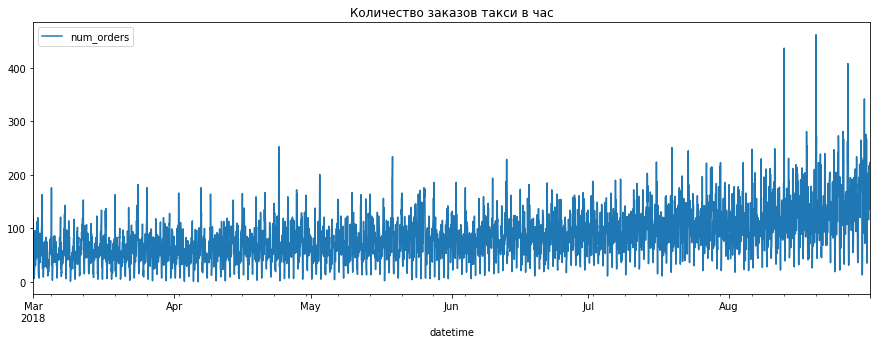

In [4]:
# График количества заказов такси в час
df.plot(figsize = (15, 5), title = 'Количество заказов такси в час')
df.describe()

,num_orders,rolling_mean
count,184.000000,175.000000
mean,2026.146739,1999.926857
std,635.874120,547.629114
min,1076.000000,1311.200000
25%,1547.500000,1572.700000
50%,1911.500000,1917.600000
75%,2349.750000,2362.400000
max,4090.000000,3555.700000


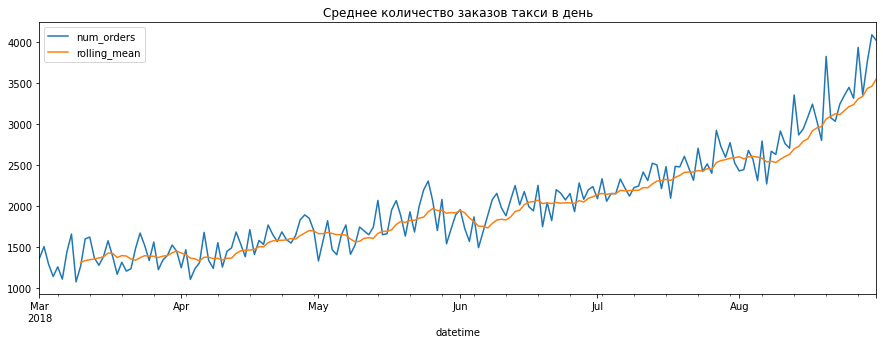

In [5]:
# График среднего количества заказов такси в день
df_d = df.resample('1D').sum()
df_d['rolling_mean'] = df_d.rolling(10).mean()
df_d.plot(figsize = (15, 5), title = 'Среднее количество заказов такси в день')
df_d.describe()

,num_orders
count,6.000000
mean,84.305369
std,25.996921
min,57.483871
25%,66.273824
50%,78.442787
75%,95.805735
max,127.651882


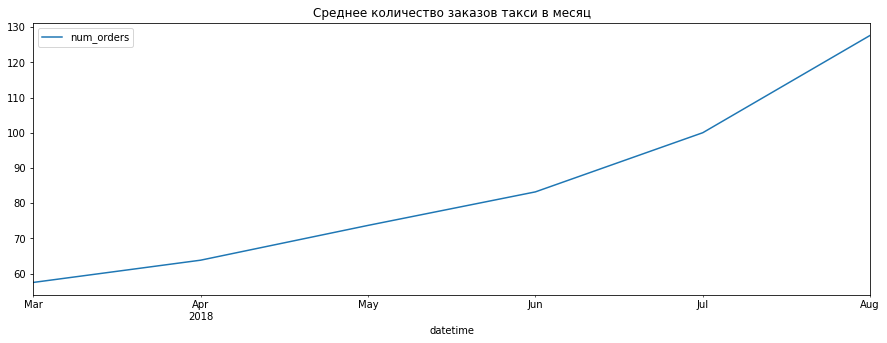

In [6]:
# График среднего количества заказов такси в месяц
df_m = df.resample('1M').mean()
df_m.plot(figsize = (15, 5), title = 'Среднее количество заказов такси в месяц')
df_m.describe()

In [7]:
# Срез дат
decomposed = seasonal_decompose(df['2018-03-01':'2018-03-03'])

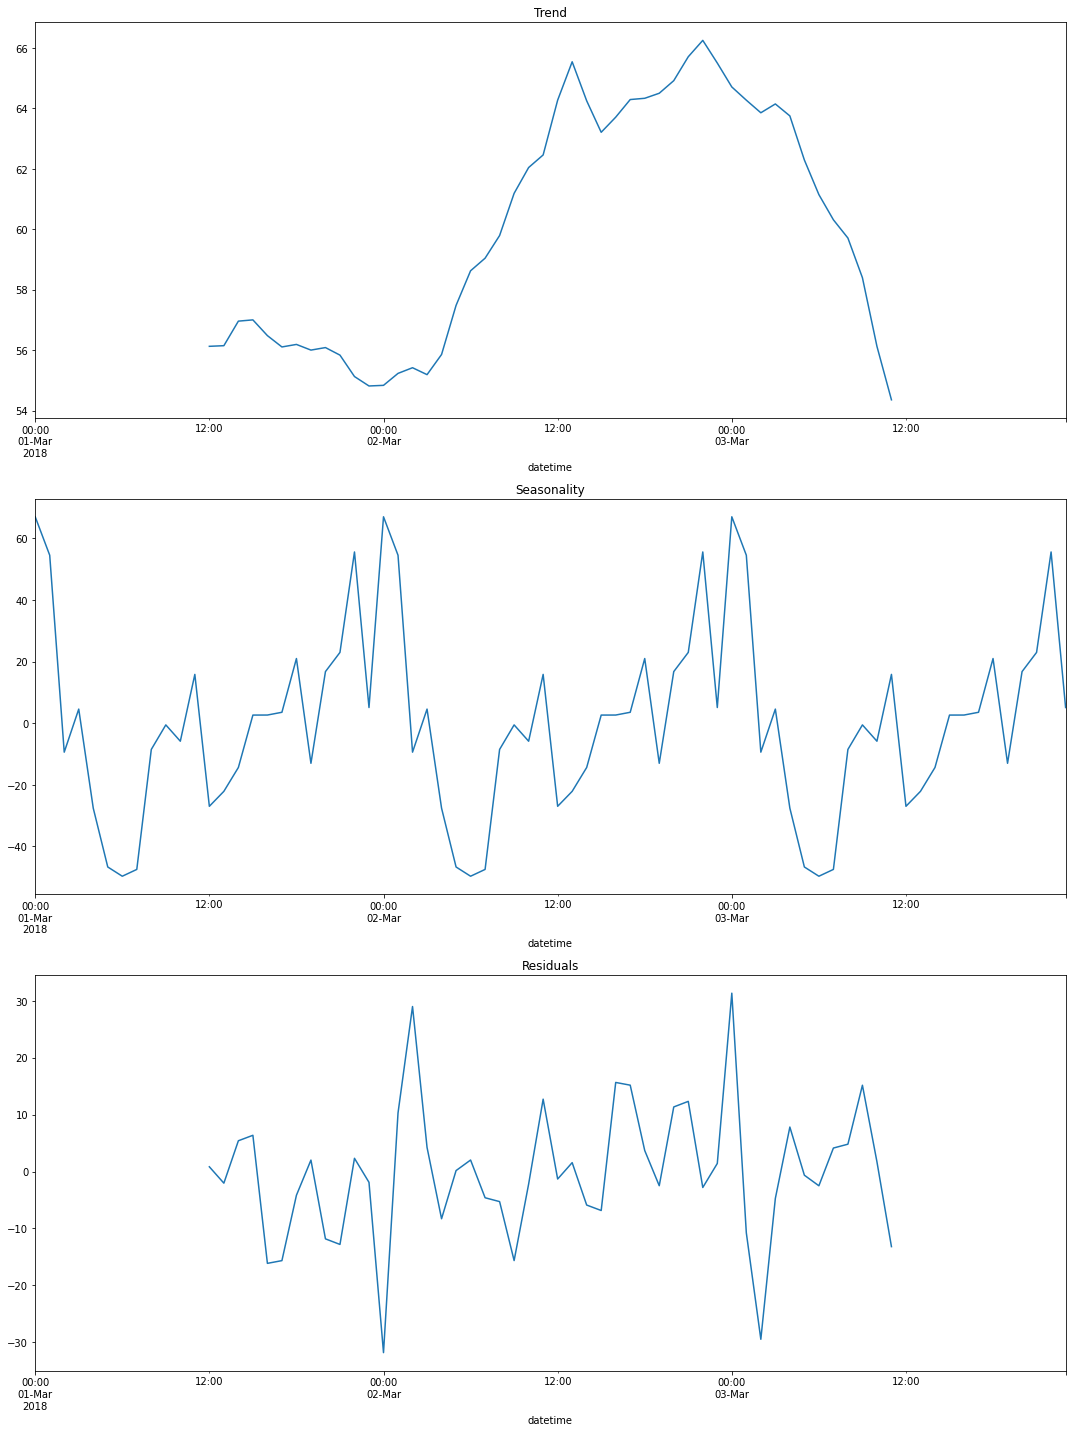

In [8]:
plt.figure(figsize=(15, 20))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

<AxesSubplot:xlabel='datetime'>

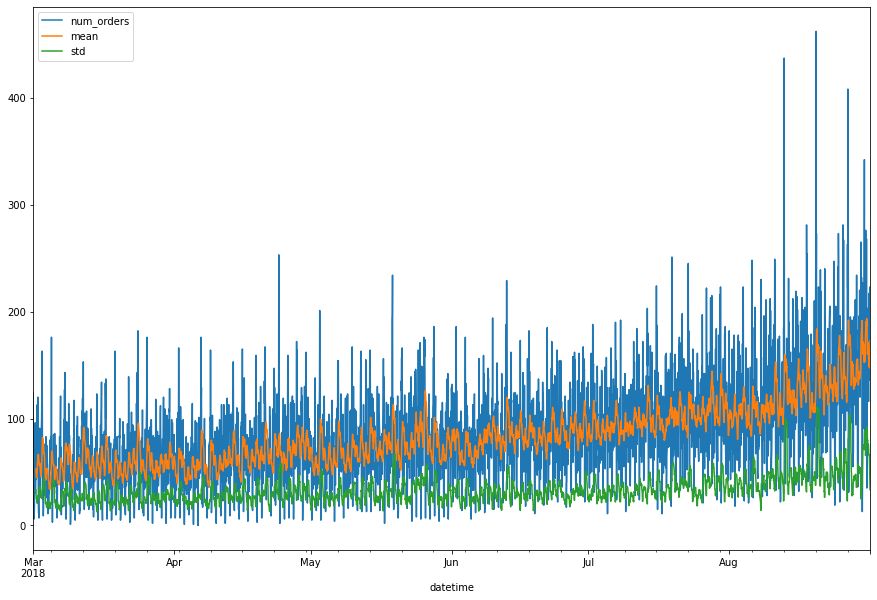

In [9]:
df['mean'] = df['num_orders'].shift().rolling(15).mean()
df['std'] = df['num_orders'].shift().rolling(15).std()
df.plot(figsize=(15, 10)) 

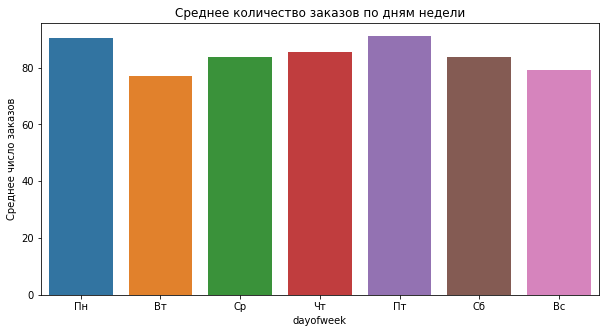

In [10]:
df['dayofweek'] = df.index.dayofweek

# Среднее количество заказов по каждому дню недели
weekly_pattern = df.groupby('dayofweek')['num_orders'].mean()

plt.figure(figsize=(10, 5))
sns.barplot(x=weekly_pattern.index, y=weekly_pattern.values)
plt.title('Среднее количество заказов по дням недели')
plt.ylabel('Среднее число заказов')
plt.xticks(ticks=range(7), labels=['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'])
plt.show()

In [11]:
from statsmodels.tsa.stattools import adfuller

series = df['num_orders'].dropna()

# Применяем ADF-тест
result = adfuller(series)

print('ADF Statistic: {:.4f}'.format(result[0]))
print('p-value: {:.4f}'.format(result[1]))
print('Used lags: {}'.format(result[2]))
print('Number of observations: {}'.format(result[3]))
print('Critical values:')
for key, value in result[4].items():
    print(f'   {key}: {value:.4f}')

alpha = 0.05
if result[1] < alpha:
    print("Отвергаем нулевую гипотезу — ряд стационарен.")
else:
    print("Не удалось отвергнуть нулевую гипотезу — ряд нестационарен.")

ADF Statistic: -3.0689
p-value: 0.0289
Used lags: 30
Number of observations: 4385
Critical values:
   1%: -3.4318
   5%: -2.8622
   10%: -2.5671
Отвергаем нулевую гипотезу — ряд стационарен.


**Выводы:**

В данных наблюдаются выраженные суточные сезонности, наибольшее число заказов в 12 часов ночи. Наблюдается недельная сезонность, так в среднем большее число заказов в пятницу и наименьшее во вторник. Также наблюдается общий постоянный тренд на рост численности заказов за весь период анализа.

Важно отметить, что большая доля остатков в конце анализируемого периода, что имеет значительно большее влияние на обучение тестовых данных. Начальные данные не являются стационарными, но после корректировки разности временного ряда данные стали стационарными и их можно прогнозировать.

## Обучение

In [12]:
# Функция для создания дополнительных признаков
def make_features(df, max_lag, rolling_mean_size):
    df_f = df.copy()
    df_f['dayofweek'] = df_f.index.dayofweek
    df_f['hour'] = df_f.index.hour
    
    for lag in range(1, max_lag + 1):
        df_f['lag_{}'.format(lag)] = df_f['num_orders'].shift(lag)

    df_f['rolling_mean'] = df_f['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    return df_f.dropna()

df_f = make_features(df, max_lag=24, rolling_mean_size=24)
df_f.head()

,num_orders,mean,std,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-02 00:00:00,90,60.533333,22.427237,4,0,58.0,113.0,66.0,61.0,45.0,...,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,56.833333
2018-03-02 01:00:00,120,61.933333,23.617387,4,1,90.0,58.0,113.0,66.0,61.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,55.416667
2018-03-02 02:00:00,75,65.666667,27.988943,4,2,120.0,90.0,58.0,113.0,66.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,56.875000
2018-03-02 03:00:00,64,64.266667,26.865981,4,3,75.0,120.0,90.0,58.0,113.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,57.041667
2018-03-02 04:00:00,20,66.533333,25.147754,4,4,64.0,75.0,120.0,90.0,58.0,...,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,56.958333


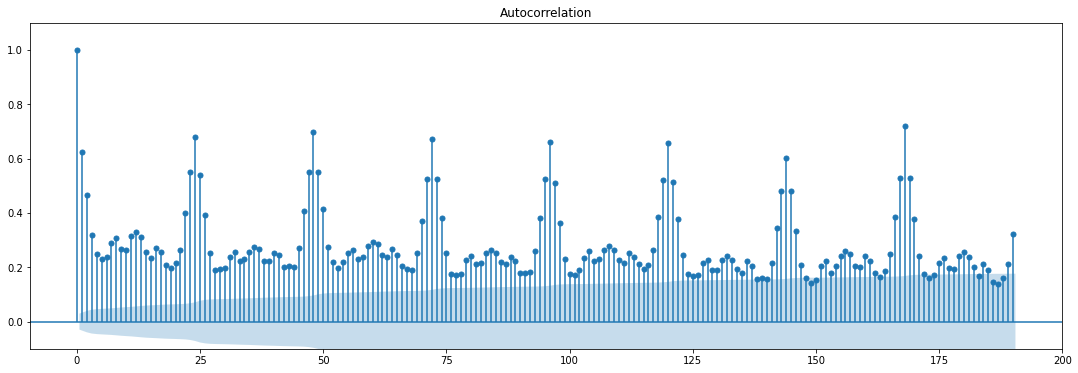

In [13]:
ts = df['num_orders']
fig = tsaplots.plot_acf(ts,lags= 190)
fig.set_size_inches(18.5, 6)
plt.ylim(-.1, 1.1)
plt.show() 


In [14]:
# Разделение данных на тренировочную и тестовую выборку
train, test = train_test_split(df_f, shuffle = False, test_size = 0.1)

X_train = train.drop('num_orders', axis=1)
y_train = train['num_orders']
X_test = test.drop('num_orders', axis=1)
y_test = test['num_orders']

In [15]:
# Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# CatBoost
cb_model = CatBoostRegressor(verbose=0, random_state=42)
cb_model.fit(X_train, y_train)

**Выводы:**
На этапе обучения была создана функция make_features для создания признаков.
Обучающие и тестовые данные были разделены с сохранением временного порядка.

Обучены 3 модели:
- LinearRegression
- RandomForestRegressor 
- CatBoostRegressor

## Тестирование

In [16]:
# Создаем функцию для оценки метрики качества
rmse_scorer = make_scorer(
    mean_squared_error,
    greater_is_better=False,
    squared=False
)

tscv = TimeSeriesSplit(n_splits=5)

models = {
    'Linear Regression': lr_model,
    'Random Forest': rf_model,
    'CatBoost': cb_model
}

for name, model in models.items():
    scores = cross_val_score(
        model, X_train, y_train,
        cv=tscv,
        scoring=rmse_scorer,
        n_jobs=-1
    )
    mean_rmse = -np.mean(scores)
    std_rmse  = np.std(scores)
    print(f"{name} CV RMSE: {mean_rmse:.3f} ± {std_rmse:.3f}")

Linear Regression CV RMSE: 27.216 ± 3.526
Random Forest CV RMSE: 25.257 ± 3.637
CatBoost CV RMSE: 24.287 ± 3.677


In [17]:
# Оценка на тестовых данных лучшей модели CatBoost
cb_preds = cb_model.predict(X_test)
cb_rmse = mean_squared_error(y_test, cb_preds, squared=False)
print(f'RMSE: {cb_rmse:.2f}')

RMSE: 41.04


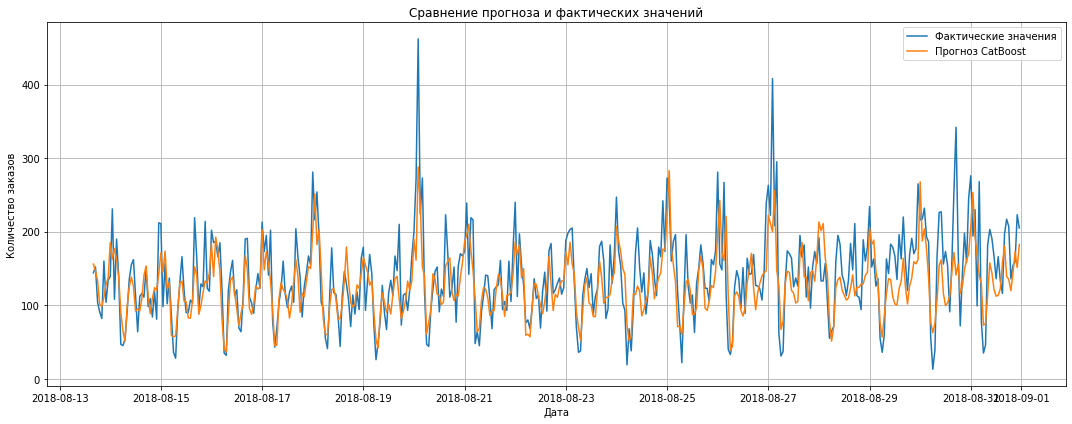

In [18]:
# График
plt.figure(figsize=(15, 6))
plt.plot(y_test.index, y_test.values, label='Фактические значения')
plt.plot(y_test.index, cb_preds, label='Прогноз CatBoost')
plt.title('Сравнение прогноза и фактических значений')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**Выводы**

Модель довольно хорошо предсказывает пики и падения в начале и середине выборки. На участках ближе к концу ряда модель заметно недооценивает реальные пики спроса, вероятно, это связано с ростом «шума» в этом промежутке.

## Итоговые выводы ##

На основе проведенного исследования, была обнаруженна дневная сезоннность данных и обучены 3 модели.
На основе оценок RMSE лучше всего спрос прогнозирует модель Cat Boost, т.к. имеет наименьший показатель RMSE 


## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Данные проанализированы
- [x]  Модель обучена, гиперпараметры подобраны
- [x]  Качество моделей проверено, выводы сделаны
- [x]  Значение *RMSE* на тестовой выборке не больше 48